In [1]:
import sys

#!pip uninstall torch
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1


import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#!pip install "git+https://github.com/facebookresearch/pytorch3d.git"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2

In [2]:
import torch
import matplotlib.pyplot as plt

from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
)

In [10]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import torch
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)
class HarmonicEmbedding(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, omega0=0.1):
        """
        Given an input tensor `x` of shape [minibatch, ... , dim],
        the harmonic embedding layer converts each feature
        in `x` into a series of harmonic features `embedding`
        as follows:
            embedding[..., i*dim:(i+1)*dim] = [
                sin(x[..., i]),
                sin(2*x[..., i]),
                sin(4*x[..., i]),
                ...
                sin(2**(self.n_harmonic_functions-1) * x[..., i]),
                cos(x[..., i]),
                cos(2*x[..., i]),
                cos(4*x[..., i]),
                ...
                cos(2**(self.n_harmonic_functions-1) * x[..., i])
            ]

        Note that `x` is also premultiplied by `omega0` before
        evaluating the harmonic functions.
        """
        super().__init__()
        self.register_buffer(
            'frequencies',
            omega0 * (2.0 ** torch.arange(n_harmonic_functions)),
        )
    def forward(self, x):
        """
        Args:
            x: tensor of shape [..., dim]
        Returns:
            embedding: a harmonic embedding of `x`
                of shape [..., n_harmonic_functions * dim * 2]
        """
        embed = (x[..., None] * self.frequencies).view(*x.shape[:-1], -1)
        return torch.cat((embed.sin(), embed.cos()), dim=-1)


class NeuralRadianceField(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, n_hidden_neurons=256):
        super().__init__()
        """
        Args:
            n_harmonic_functions: The number of harmonic functions
                used to form the harmonic embedding of each point.
            n_hidden_neurons: The number of hidden units in the
                fully connected layers of the MLPs of the model.
        """

        # The harmonic embedding layer converts input 3D coordinates
        # to a representation that is more suitable for
        # processing with a deep neural network.
        self.harmonic_embedding = HarmonicEmbedding(n_harmonic_functions)

        # The dimension of the harmonic embedding.
        embedding_dim = n_harmonic_functions * 2 * 3

        # self.mlp is a simple 2-layer multi-layer perceptron
        # which converts the input per-point harmonic embeddings
        # to a latent representation.
        # Not that we use Softplus activations instead of ReLU.
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
        )

        # Given features predicted by self.mlp, self.color_layer
        # is responsible for predicting a 3-D per-point vector
        # that represents the RGB color of the point.
        self.color_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons + embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, 3),
            torch.nn.Sigmoid(),
            # To ensure that the colors correctly range between [0-1],
            # the layer is terminated with a sigmoid layer.
        )

        # The density layer converts the features of self.mlp
        # to a 1D density value representing the raw opacity
        # of each point.
        self.density_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons, 1),
            torch.nn.Softplus(beta=10.0),
            # Sofplus activation ensures that the raw opacity
            # is a non-negative number.
        )

        # We set the bias of the density layer to -1.5
        # in order to initialize the opacities of the
        # ray points to values close to 0.
        # This is a crucial detail for ensuring convergence
        # of the model.
        self.density_layer[0].bias.data[0] = -1.5

    def _get_densities(self, features):
        """
        This function takes `features` predicted by `self.mlp`
        and converts them to `raw_densities` with `self.density_layer`.
        `raw_densities` are later mapped to [0-1] range with
        1 - inverse exponential of `raw_densities`.
        """
        raw_densities = self.density_layer(features)
        return 1 - (-raw_densities).exp()

    def _get_colors(self, features, rays_directions, normals):
      # Normalize the ray directions to unit l2 norm.
      rays_directions_normed = torch.nn.functional.normalize(rays_directions, dim=-1)

      # Compute harmonic embeddings for rays
      rays_embedding = self.harmonic_embedding(rays_directions_normed)
      rays_embedding_expand = rays_embedding[..., None, :].expand(*features.shape[:-1], rays_embedding.shape[-1])

      # Phong/Blinn-Phong specular shading implementation (simplified)
      view_dir = rays_directions_normed
      light_dir = -view_dir  # For simplicity, assume light comes from view direction
      reflect_dir = 2 * (torch.sum(light_dir * normals, dim=-1, keepdim=True) * normals) - light_dir

      # Specular term using Blinn-Phong
      spec_intensity = torch.clamp(torch.sum(reflect_dir * view_dir, dim=-1, keepdim=True), min=0.0)
      shininess = 50  # You can tune this parameter
      specular_term = torch.pow(spec_intensity, shininess)

      # Concatenate ray direction embeddings with features for final color prediction
      color_input = torch.cat((features, rays_embedding_expand), dim=-1)
      base_color = self.color_layer(color_input)

      # Add the specular term to the base color for specularity
      final_color = base_color + specular_term[..., None] * 0.3  # Weight the specular effect
      return torch.clamp(final_color, 0.0, 1.0)

    def estimate_normals(self, ray_bundle, densities):
      """
      Estimate surface normals by calculating the gradients of the densities along the ray points.
      """
      # Assuming densities is of shape [minibatch, ..., num_points_per_ray, 1]
      grad_density = torch.autograd.grad(
          outputs=densities, inputs=ray_bundle.origins,
          grad_outputs=torch.ones_like(densities),
          create_graph=True, retain_graph=True
      )[0]
      # Normalize the gradients to get the normals
      normals = torch.nn.functional.normalize(grad_density, dim=-1)
      return normals



    def forward(
        self,
        ray_bundle: RayBundle,
        train_mode=True,
        **kwargs,
    ):
        """
        The forward function accepts the parametrizations of
        3D points sampled along projection rays. The forward
        pass is responsible for attaching a 3D vector
        and a 1D scalar representing the point's
        RGB color and opacity respectively.

        Args:
            ray_bundle: A RayBundle object containing the following variables:
                origins: A tensor of shape `(minibatch, ..., 3)` denoting the
                    origins of the sampling rays in world coords.
                directions: A tensor of shape `(minibatch, ..., 3)`
                    containing the direction vectors of sampling rays in world coords.
                lengths: A tensor of shape `(minibatch, ..., num_points_per_ray)`
                    containing the lengths at which the rays are sampled.

        Returns:
            rays_densities: A tensor of shape `(minibatch, ..., num_points_per_ray, 1)`
                denoting the opacity of each ray point.
            rays_colors: A tensor of shape `(minibatch, ..., num_points_per_ray, 3)`
                denoting the color of each ray point.
        """

        # Ensure ray origins track gradients only in training mode
        if train_mode:
            ray_bundle.origins.requires_grad_(True)
        else:
            ray_bundle.origins.requires_grad_(False)

        # We first convert the ray parametrizations to world
        # coordinates with `ray_bundle_to_ray_points`.
        rays_points_world = ray_bundle_to_ray_points(ray_bundle)
        # rays_points_world.shape = [minibatch x ... x 3]

        # For each 3D world coordinate, we obtain its harmonic embedding.
        embeds = self.harmonic_embedding(
            rays_points_world
        )
        # embeds.shape = [minibatch x ... x self.n_harmonic_functions*6]

        # self.mlp maps each harmonic embedding to a latent feature space.
        features = self.mlp(embeds)
        # features.shape = [minibatch x ... x n_hidden_neurons]

        # Finally, given the per-point features,
        # execute the density and color branches.

        rays_densities = self._get_densities(features)
        # rays_densities.shape = [minibatch x ... x 1]

        # Compute normals only if tracking gradients
        if train_mode:
            normals = self.estimate_normals(ray_bundle, rays_densities)
        else:
            normals = torch.zeros_like(ray_bundle.directions)  # Dummy normals for inference

        # Get colors using the computed normals
        rays_colors = self._get_colors(features, ray_bundle.directions, normals)
        # rays_colors.shape = [minibatch x ... x 3]

        return rays_densities, rays_colors

    def batched_forward(
        self,
        ray_bundle: RayBundle,
        n_batches: int = 16,
        **kwargs,
    ):
        """
        This function is used to allow for memory efficient processing
        of input rays. The input rays are first split to `n_batches`
        chunks and passed through the `self.forward` function one at a time
        in a for loop. Combined with disabling PyTorch gradient caching
        (`torch.no_grad()`), this allows for rendering large batches
        of rays that do not all fit into GPU memory in a single forward pass.
        In our case, batched_forward is used to export a fully-sized render
        of the radiance field for visualization purposes.

        Args:
            ray_bundle: A RayBundle object containing the following variables:
                origins: A tensor of shape `(minibatch, ..., 3)` denoting the
                    origins of the sampling rays in world coords.
                directions: A tensor of shape `(minibatch, ..., 3)`
                    containing the direction vectors of sampling rays in world coords.
                lengths: A tensor of shape `(minibatch, ..., num_points_per_ray)`
                    containing the lengths at which the rays are sampled.
            n_batches: Specifies the number of batches the input rays are split into.
                The larger the number of batches, the smaller the memory footprint
                and the lower the processing speed.

        Returns:
            rays_densities: A tensor of shape `(minibatch, ..., num_points_per_ray, 1)`
                denoting the opacity of each ray point.
            rays_colors: A tensor of shape `(minibatch, ..., num_points_per_ray, 3)`
                denoting the color of each ray point.

        """

        # Parse out shapes needed for tensor reshaping in this function.
        n_pts_per_ray = ray_bundle.lengths.shape[-1]
        spatial_size = [*ray_bundle.origins.shape[:-1], n_pts_per_ray]

        # Split the rays to `n_batches` batches.
        tot_samples = ray_bundle.origins.shape[:-1].numel()
        batches = torch.chunk(torch.arange(tot_samples), n_batches)

        # For each batch, execute the standard forward pass.
        batch_outputs = [
            self.forward(
                RayBundle(
                    origins=ray_bundle.origins.view(-1, 3)[batch_idx],
                    directions=ray_bundle.directions.view(-1, 3)[batch_idx],
                    lengths=ray_bundle.lengths.view(-1, n_pts_per_ray)[batch_idx],
                    xys=None,
                ),
                train_mode=False  # No gradient tracking and normal estimation
            ) for batch_idx in batches
        ]

        # Concatenate the per-batch rays_densities and rays_colors
        # and reshape according to the sizes of the inputs.
        rays_densities, rays_colors = [
            torch.cat(
                [batch_output[output_i] for batch_output in batch_outputs], dim=0
            ).view(*spatial_size, -1) for output_i in (0, 1)
        ]
        return rays_densities, rays_colors

In [4]:
import os

import numpy as np
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    BlendParams,
    FoVPerspectiveCameras,
    look_at_view_transform,
    MeshRasterizer,
    MeshRenderer,
    PointLights,
    RasterizationSettings,
    SoftPhongShader,
    SoftSilhouetteShader,
)


# Mounted Google Drive directory path
DATA_DIR = '/content/drive/MyDrive/4030/assignment_2/data/cow_mesh'

def generate_cow_renders(
    num_views: int = 40, data_dir: str = DATA_DIR, azimuth_range: float = 180
):
    """
    This function generates `num_views` renders of a cow mesh.
    The renders are generated from viewpoints sampled at uniformly distributed
    azimuth intervals. The elevation is kept constant so that the camera's
    vertical position coincides with the equator.

    Args:
        num_views: The number of generated renders.
        data_dir: The folder that contains the cow mesh files.
        azimuth_range: number of degrees on each side of the start position to
            take samples

    Returns:
        cameras: A batch of `num_views` `FoVPerspectiveCameras` from which the
            images are rendered.
        images: A tensor of shape `(num_views, height, width, 3)` containing
            the rendered images.
        silhouettes: A tensor of shape `(num_views, height, width)` containing
            the rendered silhouettes.
    """

    # Setup
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    # Load obj file from Google Drive
    obj_filename = os.path.join(data_dir, "cow.obj")
    mesh = load_objs_as_meshes([obj_filename], device=device)

    # Normalize and center the mesh
    verts = mesh.verts_packed()
    N = verts.shape[0]
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-(center.expand(N, 3)))
    mesh.scale_verts_((1.0 / float(scale)))

    # Get a batch of viewing angles
    elev = torch.linspace(0, 0, num_views)  # constant elevation
    azim = torch.linspace(-azimuth_range, azimuth_range, num_views) + 180.0

    # Place a point light in front of the object
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    # Initialize a perspective camera with different viewing angles
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    # Define rasterization and shading settings
    raster_settings = RasterizationSettings(
        image_size=128, blur_radius=0.0, faces_per_pixel=1
    )

    # Create a Phong renderer
    blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(0.0, 0.0, 0.0))
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
        shader=SoftPhongShader(
            device=device, cameras=cameras, lights=lights, blend_params=blend_params
        ),
    )

    # Create a batch of meshes by repeating the cow mesh
    meshes = mesh.extend(num_views)

    # Render the cow mesh from each viewing angle
    target_images = renderer(meshes, cameras=cameras, lights=lights)

    # Rasterization settings for silhouette rendering
    sigma = 1e-4
    raster_settings_silhouette = RasterizationSettings(
        image_size=128, blur_radius=np.log(1.0 / 1e-4 - 1.0) * sigma, faces_per_pixel=50
    )

    # Silhouette renderer
    renderer_silhouette = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras, raster_settings=raster_settings_silhouette
        ),
        shader=SoftSilhouetteShader(),
    )

    # Render silhouette images
    silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)

    # Binary silhouettes
    silhouette_binary = (silhouette_images[..., 3] > 1e-4).float()

    return cameras, target_images[..., :3], silhouette_binary


In [5]:
import torch
from pytorch3d.transforms import so3_exp_map
import matplotlib.pyplot as plt
from tqdm import tqdm
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)

def huber(x, y, scaling=0.1):
    """
    A helper function for evaluating the smooth L1 (huber) loss
    between the rendered silhouettes and colors.
    """
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

def sample_images_at_mc_locs(target_images, sampled_rays_xy):
    """
    Given a set of Monte Carlo pixel locations `sampled_rays_xy`,
    this method samples the tensor `target_images` at the
    respective 2D locations.

    This function is used in order to extract the colors from
    ground truth images that correspond to the colors
    rendered using `MonteCarloRaysampler`.
    """
    ba = target_images.shape[0]
    dim = target_images.shape[-1]
    spatial_size = sampled_rays_xy.shape[1:-1]
    # In order to sample target_images, we utilize
    # the grid_sample function which implements a
    # bilinear image sampler.
    # Note that we have to invert the sign of the
    # sampled ray positions to convert the NDC xy locations
    # of the MonteCarloRaysampler to the coordinate
    # convention of grid_sample.
    images_sampled = torch.nn.functional.grid_sample(
        target_images.permute(0, 3, 1, 2),
        -sampled_rays_xy.view(ba, -1, 1, 2),  # note the sign inversion
        align_corners=True
    )
    return images_sampled.permute(0, 2, 3, 1).view(
        ba, *spatial_size, dim
    )

def show_full_render(
    neural_radiance_field, camera,
    target_image, target_silhouette,
    renderer_grid, loss_history_color,
    loss_history_sil,
):
    """
    This is a helper function for visualizing the
    intermediate results of the learning.

    Since the `NeuralRadianceField` suffers from
    a large memory footprint, which does not let us
    render the full image grid in a single forward pass,
    we utilize the `NeuralRadianceField.batched_forward`
    function in combination with disabling the gradient caching.
    This chunks the set of emitted rays to batches and
    evaluates the implicit function on one batch at a time
    to prevent GPU memory overflow.
    """

    # Prevent gradient caching.
    with torch.no_grad():
        # Render using the grid renderer and the
        # batched_forward function of neural_radiance_field.
        rendered_image_silhouette, _ = renderer_grid(
            cameras=camera,
            volumetric_function=neural_radiance_field.batched_forward
        )
        # Split the rendering result to a silhouette render
        # and the image render.
        rendered_image, rendered_silhouette = (
            rendered_image_silhouette[0].split([3, 1], dim=-1)
        )

    # Generate plots.
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.ravel()
    clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
    ax[0].plot(list(range(len(loss_history_color))), loss_history_color, linewidth=1)
    ax[1].imshow(clamp_and_detach(rendered_image))
    ax[2].imshow(clamp_and_detach(rendered_silhouette[..., 0]))
    ax[3].plot(list(range(len(loss_history_sil))), loss_history_sil, linewidth=1)
    ax[4].imshow(clamp_and_detach(target_image))
    ax[5].imshow(clamp_and_detach(target_silhouette))
    for ax_, title_ in zip(
        ax,
        (
            "loss color", "rendered image", "rendered silhouette",
            "loss silhouette", "target image",  "target silhouette",
        )
    ):
        if not title_.startswith('loss'):
            ax_.grid("off")
            ax_.axis("off")
        ax_.set_title(title_)
    fig.canvas.draw()
    return fig

def generate_rotating_nerf(neural_radiance_field, target_cameras, renderer_grid, n_frames = 50, device=torch.device("cpu")):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(-3.14, 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Rendering rotating NeRF ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        # Note that we again render with `NDCMultinomialRaysampler`
        # and the batched_forward function of neural_radiance_field.
        frames.append(
            renderer_grid(
                cameras=camera,
                volumetric_function=neural_radiance_field.batched_forward,
            )[0][..., :3]
        )
    return torch.cat(frames)

In [6]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.

import matplotlib.pyplot as plt


def image_grid(
    images,
    rows=None,
    cols=None,
    fill: bool = True,
    show_axes: bool = False,
    rgb: bool = True,
):
    """
    A util function for plotting a grid of images.

    Args:
        images: (N, H, W, 4) array of RGBA images
        rows: number of rows in the grid
        cols: number of columns in the grid
        fill: boolean indicating if the space between images should be filled
        show_axes: boolean indicating if the axes of the plots should be visible
        rgb: boolean, If True, only RGB channels are plotted.
            If False, only the alpha channel is plotted.

    Returns:
        None
    """
    if (rows is None) != (cols is None):
        raise ValueError("Specify either both rows and cols or neither.")

    if rows is None:
        rows = len(images)
        cols = 1

    gridspec_kw = {"wspace": 0.0, "hspace": 0.0} if fill else {}
    fig, axarr = plt.subplots(rows, cols, gridspec_kw=gridspec_kw, figsize=(15, 9))
    bleed = 0
    fig.subplots_adjust(left=bleed, bottom=bleed, right=(1 - bleed), top=(1 - bleed))

    for ax, im in zip(axarr.ravel(), images):
        if rgb:
            # only render RGB channels
            ax.imshow(im[..., :3])
        else:
            # only render Alpha channel
            ax.imshow(im[..., 3])
        if not show_axes:
            ax.set_axis_off()

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [11]:
target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40, azimuth_range=180)
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

Generated 40 images/silhouettes/cameras.


In [12]:
render_size = target_images.shape[1] * 2

volume_extent_world = 3.0

raysampler_mc = MonteCarloRaysampler(
    min_x = -1.0,
    max_x = 1.0,
    min_y = -1.0,
    max_y = 1.0,
    n_rays_per_image=750,
    n_pts_per_ray=128,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

In [13]:
raymarcher = EmissionAbsorptionRaymarcher()

In [14]:
renderer_mc = ImplicitRenderer(raysampler=raysampler_mc, raymarcher=raymarcher)

In [15]:
render_size = target_images.shape[1] * 2
volume_extent_world = 3.0
raysampler_grid = NDCMultinomialRaysampler(
    image_height=render_size,
    image_width=render_size,
    n_pts_per_ray=128,
    min_depth=0.1,
    max_depth=volume_extent_world)

raymarcher = EmissionAbsorptionRaymarcher()

In [16]:
renderer_grid = ImplicitRenderer(raysampler=raysampler_grid, raymarcher=raymarcher)

In [17]:
neural_radiance_field = NeuralRadianceField()

In [18]:
torch.manual_seed(1)
renderer_grid = renderer_grid.to(device)
renderer_mc = renderer_mc.to(device)
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)
neural_radiance_field = neural_radiance_field.to(device)

In [19]:
lr = 1e-3
optimizer = torch.optim.Adam(neural_radiance_field.parameters(), lr=lr)
batch_size = 6
n_iter = 3000

In [26]:
loss_history_color, loss_history_sil = [], []

# Specify the directory to save the model checkpoints
checkpoint_dir = "/content/drive/MyDrive/4030/assignment_2/model_2"
os.makedirs(checkpoint_dir, exist_ok=True)

for iteration in range(n_iter):
  #print(f"Iteration: {iteration}/3000", end='\r', flush=True)
  if iteration == round(n_iter * 0.75):
      print('Decreasing LR 10-fold ...')
      optimizer = torch.optim.Adam(
          neural_radiance_field.parameters(), lr=lr * 0.1
      )

  optimizer.zero_grad()
  batch_idx = torch.randperm(len(target_cameras))[:batch_size]

  batch_cameras = FoVPerspectiveCameras(
      R = target_cameras.R[batch_idx],
      T = target_cameras.T[batch_idx],
      znear = target_cameras.znear[batch_idx],
      zfar = target_cameras.zfar[batch_idx],
      aspect_ratio = target_cameras.aspect_ratio[batch_idx],
      fov = target_cameras.fov[batch_idx],
      device = device)

  rendered_images_silhouettes, sampled_rays = renderer_mc(
      cameras=batch_cameras,
      volumetric_function=neural_radiance_field
  )

  rendered_images, rendered_silhouettes = (
      rendered_images_silhouettes.split([3, 1], dim=-1)
  )

  silhouettes_at_rays = sample_images_at_mc_locs(
      target_silhouettes[batch_idx, ..., None],
      sampled_rays.xys
  )

  sil_err = huber(
      rendered_silhouettes,
      silhouettes_at_rays,
  ).abs().mean()
  colors_at_rays = sample_images_at_mc_locs(
      target_images[batch_idx],
      sampled_rays.xys
  )

  color_err = huber(
      rendered_images,
      colors_at_rays,
  ).abs().mean()

  loss = color_err + sil_err
  loss_history_color.append(float(color_err))
  loss_history_sil.append(float(sil_err))

  loss.backward()
  optimizer.step()

  # Save model and optimizer every 1000 iterations
  if iteration % 1000 == 0:
      print("Saving model...")
      checkpoint_path = os.path.join(checkpoint_dir, f"model_checkpoint_{iteration}.pth")
      torch.save({
          'iteration': iteration,
          'model_state_dict': neural_radiance_field.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss_history_color': loss_history_color,
          'loss_history_sil': loss_history_sil,
      }, checkpoint_path)
      print(f"Model checkpoint saved at iteration {iteration}")

  # Visualize the full renders every 100 iterations.
  if iteration % 100 == 0:
      show_idx = torch.randperm(len(target_cameras))[:1]
      fig = show_full_render(
          neural_radiance_field,
          FoVPerspectiveCameras(
              R = target_cameras.R[show_idx],
              T = target_cameras.T[show_idx],
              znear = target_cameras.znear[show_idx],
              zfar = target_cameras.zfar[show_idx],
              aspect_ratio = target_cameras.aspect_ratio[show_idx],
              fov = target_cameras.fov[show_idx],
              device = device,
          ),
          target_images[show_idx][0],
          target_silhouettes[show_idx][0],
          renderer_grid,
          loss_history_color,
          loss_history_sil,
      )
      fig.savefig(f'intermediate_{iteration}')

Output hidden; open in https://colab.research.google.com to view.

Rendering rotating NeRF ...


100%|██████████| 15/15 [00:36<00:00,  2.43s/it]


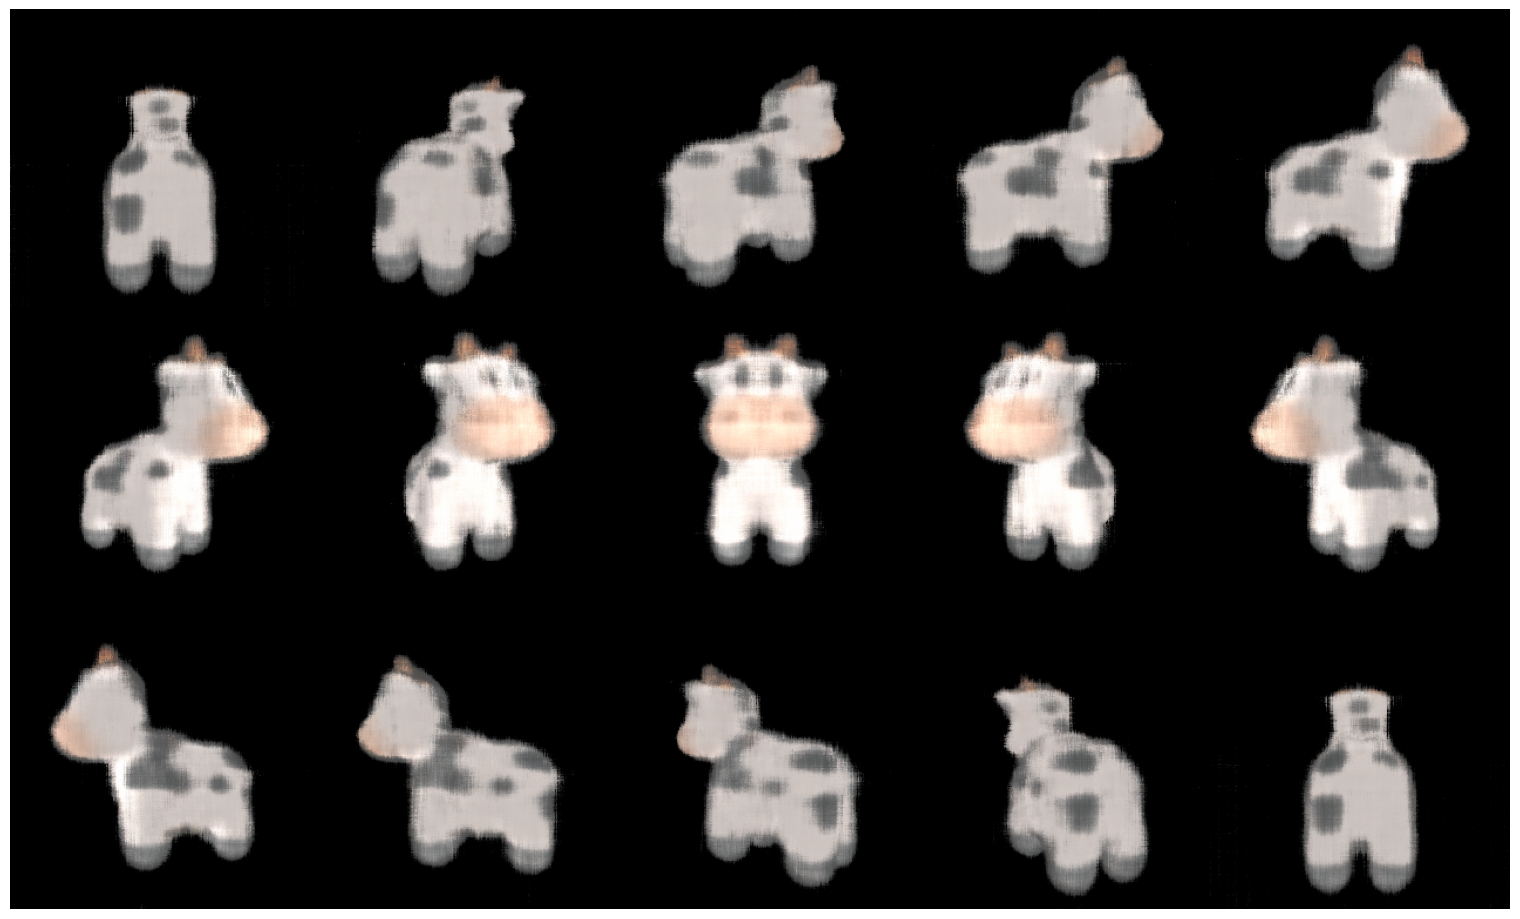

In [27]:
with torch.no_grad():
    rotating_nerf_frames = generate_rotating_nerf(neural_radiance_field, target_cameras, renderer_grid, n_frames=3*5, device=device)

image_grid(rotating_nerf_frames.clamp(0., 1.).cpu().numpy(), rows=3, cols=5, rgb=True, fill=True)
plt.show()

In [ ]:
# Load the model checkpoint
checkpoint_path = "/content/drive/MyDrive/4030/model_checkpoint_1000.pth"  # Specify the checkpoint to load
checkpoint = torch.load(checkpoint_path)

# Load state dictionaries and continue training from saved state
neural_radiance_field.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_iteration = checkpoint['iteration'] + 1  # Resume from the next iteration
loss_history_color = checkpoint['loss_history_color']
loss_history_sil = checkpoint['loss_history_sil']

print(f"Resuming training from iteration {start_iteration}")
